# The vertical Sato-Tate-Distribution



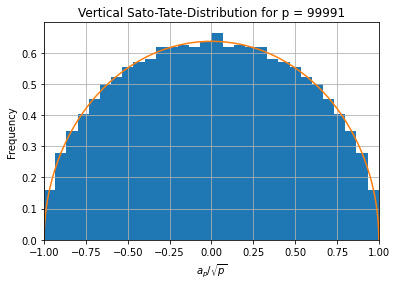

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from math import asin, log, sqrt

def ecs_over_F(p):
    F = GF(p)
    the_1728_j = F(1728)

    js = list(range(1,p))
    js.remove(the_1728_j) #needs to be handled separately
    cardinalities = np.array([])
    for j in my_simple_js:
        E = EllipticCurve_from_j(F(j), minimal_twist=False)
        np.append(cardinalities, E.cardinality())
        # |E| + |E'| = 2p+2
    cardinalities = (cardinalities - (p+1))/float(2 * sqrt(p))
    np.append(cardinalities, -cardinalities)
    return cardinalities

def normalized_aps(p):
    F = GF(p)
    the_1728_j = F(1728)

    js = list(range(1,p))
    js.remove(the_1728_j) #needs to be handled separately
    without_twist_aps = (np.array([EllipticCurve_from_j(F(j), minimal_twist=False).cardinality() for j in js]) - (p+1))/float(2 * sqrt(p))

    all_aps = np.append(without_twist_aps, -without_twist_aps)
    return all_aps

def histogram(v, num_bins, p):
    n, bins, patches = plt.hist(v, num_bins, density=True)
    angle = np.linspace(0, np.pi, 150) 
    radius = 1
    x = radius * np.cos(angle) 
    y = radius * np.sin(angle) * 2 / np.pi #stretching so that area = 1
    plt.plot(x, y)
    plt.xlabel('$a_p/\\sqrt{p}$')
    plt.ylabel('Frequency')
    plt.title('Vertical Sato-Tate-Distribution for p = {}'.format(p))
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    plt.xlim(-1,1)
    #plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

p = 99991
v = normalized_aps(p)
histogram(v, 30, p)

In [67]:
p = 99991
F = GF(p)
the_1728_j = F(1728)

my_simple_js = list(range(1,p))
my_simple_js.remove(the_1728_j)
my_ecs_over_F = []
for j in my_simple_js:
    E = EllipticCurve_from_j(F(j), minimal_twist=False)
    my_ecs_over_F.append(E)
    Etwist = E.quadratic_twist()
    my_ecs_over_F.append(Etwist)
ap_list = np.array([E.cardinality() for E in my_ecs_over_F])

def normalized_aps(p):
    F = GF(p)
    the_1728_j = F(1728)

    js = list(range(1,p))
    js.remove(the_1728_j) #needs to be handled separately
    without_twist_aps = (np.array([EllipticCurve_from_j(F(j), minimal_twist=False).cardinality() for j in js]) - (p+1))/float(2 * sqrt(p))

    all_aps = np.append(without_twist_aps, -without_twist_aps)
    return all_aps


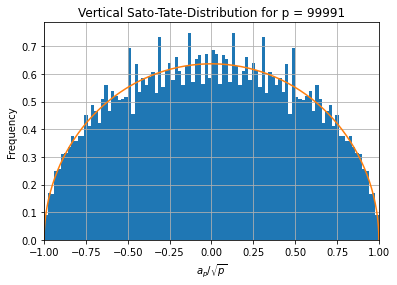

In [45]:
ap_list = np.array([E.cardinality() for E in my_ecs_over_F])
v = (ap_list - p-1)/float(2 * math.sqrt(p))

n, bins, patches = plt.hist(v, num_bins, density=True)
angle = np.linspace(0, np.pi, 150) 
radius = 1
x = radius * np.cos(angle) 
y = radius * np.sin(angle) * 2 / np.pi #stretching so that area = 1
plt.plot(x, y)
plt.xlabel('$a_p/\\sqrt{p}$')
plt.ylabel('Frequency')
plt.title('Vertical Sato-Tate-Distribution for p = {}'.format(p))
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(-1,1)
#plt.ylim(0, 1)
plt.grid(True)
plt.show()